In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
# load data
df_1 = pd.read_csv('pdb_data_no_dups.csv')
df_2 = pd.read_csv('pdb_data_seq.csv')

In [3]:
def data_preprocess(df_info, df_seqs):
    '''
    Preprocess csv protein sequence and information data
    Input:
    df_info: pd dataframe from info csv
    df_seqs: pd dataframe from sequence csv
    Output:
    df_new: joint preprocessed pd dataframe
    '''
    
    # remove unwanted features
    df_1= df_info.drop(['experimentalTechnique', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'], axis=1) 
    df_2= df_seqs.drop(['chainId', 'residueCount'], axis=1) 
    
    # drop duplicated based on structureId
    df1 = df_1.drop_duplicates(subset='structureId', keep='first',inplace=False)
    df2 = df_2.drop_duplicates(subset='structureId', keep='first',inplace=False)
    
    # join two dataframes
    df = pd.merge(df1, df2, left_on='structureId', right_on='structureId')
    
    # select only protein sequences
    df_select= df[df['macromoleculeType_x']=='Protein']
    
    # remove feature indicating it is protein sequences
    df_select = df_select.drop(['macromoleculeType_x', 'macromoleculeType_y'], axis=1) 
    
    
    # remove duplicate sequences and NA values
    df_new = df_select.drop_duplicates(subset='sequence', keep='first',inplace=False)
    df_new = df_new.dropna(how='any')
    
    # rename structureId to Id
    df_new.columns = ['Id', 'classification',  'sequence']
    
    return df_new

In [4]:
df = data_preprocess(df_1, df_2)

In [5]:
# count number of sequences in each classification
count = df.groupby('classification')['Id'].nunique()
count[count > 1000]

classification
HYDROLASE                                10782
IMMUNE SYSTEM                             2495
ISOMERASE                                 1540
LIGASE                                    1261
LYASE                                     2335
MEMBRANE PROTEIN                          1118
OXIDOREDUCTASE                            6242
PROTEIN BINDING                           1381
SIGNALING PROTEIN                         1914
STRUCTURAL GENOMICS, UNKNOWN FUNCTION     1515
TRANSCRIPTION                             2135
TRANSFERASE                               8122
TRANSPORT PROTEIN                         1837
UNKNOWN FUNCTION                          1033
VIRAL PROTEIN                             1499
Name: Id, dtype: int64

In [6]:
# unkown classifications
for i, row in enumerate(count):
    name = count.index[i]
    if 'UNKNOWN' in name:
        print(count.index[i], row)

HYDROLASE/UNKNOWN FUNCTION 1
METAL BINDING PROTEIN, UNKNOWN FUNCTION 2
METAL BINDING PROTEIN,UNKNOWN FUNCTION 1
ONCOPROTEIN,UNKNOWN FUNCTION 1
STRUCTURAL GENOMICS  UNKNOWN FUNCTION 1
STRUCTURAL GENOMICS UNKNOWN FUNCTION 2
STRUCTURAL GENOMICS,   UNKNOWN FUNCTION 2
STRUCTURAL GENOMICS,  UNKNOWN FUNCTION 5
STRUCTURAL GENOMICS, UNKNOWN FUNCTION 1515
STRUCTURAL GENOMICS,UNKNOWN FUNCTION 6
Structural Genomics, UNKNOWN FUNCTION 7
Structural genomics, UNKNOWN FUNCTION 1
TRANSPORT PROTEIN/UNKNOWN FUNCTION 1
UNKNOWN BACTERIAL HYDROLASE 1
UNKNOWN FUNCTION 1033
UNKNOWN FUNCTION, PROTEIN BINDING 1
UNKNOWN FUNCTION, STRUCTURAL GENOMICS 2
UNKNOWN FUNCTION/IMMUNE SYSTEM 2
UNKNOWN FUNCTION/Ligase 1
UNKNOWN PROTEIN 1
VIRAL PROTEIN, UNKNOWN FUNCTION 2


In [7]:
def seq_dict(df,n_min = 1000,include_unknown = False):
    '''
    Input:
    df: joint preprocessed dataframe
    n_min: minimum number of sequences for a given classification
    include_unknown: boolean indicating whether to include unknown classifications 
    Output:
    seqs_dict: dictionary with classifications as keys and corrresponding sequences dataframe as values
    '''
    # count number of sequences in each classification
    df_count = df.groupby('classification')['Id'].nunique()
    
    # retrieve indices of classifications that satitisfy minimum number requirements
    idx= list(df_count[df_count > n_min].index)
    
    # init dictionary
    seqs_dict =  dict()
    for typ in idx:
        # including unknown classfications
        if include_unknown:
            # store selected sections of dataframe to the corresponding key
            seqs_dict[typ] = df[df['classification'] == typ]
        # not including unknown classifications
        else:
            if 'UNKNOWN' not in typ:
                # store selected sections of dataframe to the corresponding key
                seqs_dict[typ] = df[df['classification'] == typ]
    return seqs_dict

In [8]:
seqs_dict = seq_dict(df)
#seqs_dict.keys()

In [9]:
class_totals = dict()
seq_ids = []
for i in seqs_dict:
    count = 0
    cls = seqs_dict[i]
    for j in cls.Id:
        count += 1
    class_totals[i] = count


## Hidden Markov Model

In [10]:
#Remove worst 3 rates
del seqs_dict['HYDROLASE']
del seqs_dict['TRANSFERASE']
del seqs_dict['SIGNALING PROTEIN']

In [11]:
#Declare important dictionaries
rates = dict()
static = dict()
beg_seq = dict()
def make_2D():
    r = []
    a = 0
    b = 0
    while a < 26:
        r.append(list())
        b = 0
        while b < 26:
            r[a].append(0)
            b += 1
        a += 1
    return r

j = 0
for i in seqs_dict:
    rates[i] = make_2D()
    static[i] = list()
    beg_seq[i] = list()
    j += 1
for i in static:
    j = 0
    while j < 26:
        static[i].append(0)
        beg_seq[i].append(0)
        j += 1


In [12]:
#Translate Amino Acid to num (0-25)
def decode(letter):
    return ord(letter) - 65

In [13]:
# Learning: normalizing rates of transition
#    for each letter y from x to the total 
#    probability of seeing letter x

for x in seqs_dict:
    brk = 0
    i = 0
    cnt = 0
    sq_cnt = 0
    for j in seqs_dict[x].sequence:
        sq_cnt += 1
        if sq_cnt >= (class_totals[x]): ## / 10): used for training off % of given sequences per class
            c1 = 0
            c2 = 0
            while c1 < 26:
                stat_tot = 0
                row_tot = 0
                c2 = 0
                while c2 < 26:
                    if c1 == 0:
                        stat_tot += static[x][c2]
                    row_tot += rates[x][c1][c2]
                    c2 += 1
                c2 = 0
                while c2 < 26:
                    if stat_tot > 0 and c1 == 0:
                        static[x][c2] = (static[x][c2] / stat_tot)
                        beg_seq[x][c2] = (beg_seq[x][c2] / class_totals[x])
                    if row_tot != 0:
                        rates[x][c1][c2] = (rates[x][c1][c2] / row_tot)
                    c2 += 1
                c1 += 1
            break
        i = 0 
        for l in j:
            if i == 0:
                i += 1
                prev = l
                beg_seq[x][decode(prev)] += 1
                continue
            a = decode(prev)
            b = decode(l)
            rates[x][a][b] += 1
            static[x][b] += 1
            prev = l
            i += 1
            cnt += 1

In [14]:
#Creates dictionary for each type of protein within dictionary
#   for purpose of 2D dictionary
seq_list = dict()
for x in seqs_dict:
    seq_list[x] = list()
    c = 0
    for b in seqs_dict[x].sequence:
        seq_list[x].append(b)


In [15]:
#Grading function to grade the likelihood of a sequence
#   belonging to each family, returns top 3
def gr(rates, static, beg_seq, sequence):
    first_let = ""
    grade = dict()
    for x in seqs_dict:
        grade[x] = 0
    i = 0
    for let in sequence:
        if i == 0:
            i += 1
            first_let = let
            prev = let
            continue
        a = decode(prev)
        b = decode(let)
        prev = let
        for x in seqs_dict:
            grade[x] += rates[x][a][b]
    largest = ["","",""]
    value = [0,0,0]
    for x in seqs_dict:
        grade[x] = grade[x] + beg_seq[x][decode(first_let)]
        if grade[x] > value[0]:
            largest[2] = largest[1]
            largest[1] = largest[0]
            largest[0] = x
            value[2] = value[1]
            value[1] = value[0]
            value[0] = grade[x]
        elif grade[x] > value[1]:
            largest[2] = largest[1]
            largest[1] = x
            value[2] = value[1]
            value[1] = grade[x]
        elif grade[x] > value[2]:
            largest[2] = x
            value[2] = grade[x]
    return(largest)

In [16]:
first = 0
second = 0
third = 0
wrong = 0
seq_num = 0
top3 = ["","",""]

#Create confusion matrix
confusion = dict()
i = 0
for x in seq_list:
    confusion[x] = dict()
    for y in seq_list:
        confusion[x][y] = 0


for x in seq_list:
    seq_num = 0
    for y in seq_list[x]:
        # Used for training off % of given sequences per class
        #if seq_num < (class_totals[x] / 10):
        #    seq_num += 1
        #    continue
        top3 = gr(rates, static, beg_seq, y)
        if top3[0] == x:
            first += 1
        elif top3[1] == x:
            second += 1
        elif top3[2] == x:
            third += 1
        else:
            #wr[x] += 1
            wrong += 1
        confusion[x][top3[0]] += 1

# Show the # top, 2nd and 3rd classifications correct, and outside top 3
# Show those percentages
print(first, second, third, wrong)
print(first/(first + second + third + wrong), second/(first + second + third + wrong), third/(first + second + third + wrong), wrong/(first + second + third + wrong))

7112 3630 3512 7589
0.325596300874422 0.16618596346655679 0.16078377512246486 0.34743396053655634


Graphical Representation

[0.325596300874422, 0.6525660394634437, 0.34743396053655634]


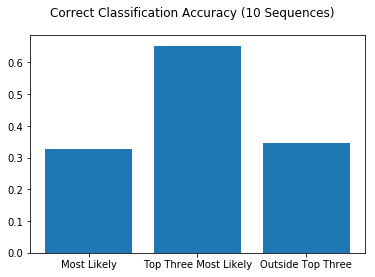

In [17]:
names = ['Most Likely', 'Top Three Most Likely', 'Outside Top Three']
values = [first/(first+second+third+wrong), (first+second+third)/(first+second+third+wrong), wrong/(first+second+third+wrong)]
plt.bar(names, values)
plt.suptitle('Correct Classification Accuracy (10 Sequences)')
print(values)

Text(0.5, 0.98, 'Classification Breakdown (10 Sequences)')

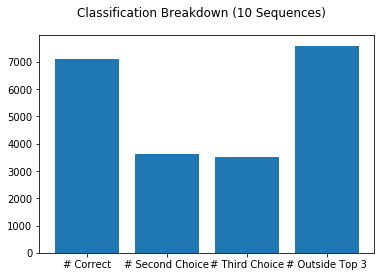

In [18]:
classif = [first, second, third, wrong]
names2 = ['# Correct','# Second Choice','# Third Choice','# Outside Top 3']
plt.bar(names2, classif)
plt.suptitle('Classification Breakdown (10 Sequences)')

In [19]:
#print (confusion)
#for x in confusion:
#    print(x, confusion[x])
#print(" ")
classes = list()
for x in confusion:
    classes.append(x)
    sm = 0
    for y in confusion:
        sm += confusion[x][y]
    for y in confusion:
        confusion[x][y] = confusion[x][y] / sm
cfsn = list()
tick_marks = [0,1,2,3,4,5,6,7,8,9]
i = 0
j = 0
for x in seqs_dict:
    cfsn.append(list())
    for y in seqs_dict:
        cfsn[i].append(confusion[x][y])
    i += 1
print(cfsn)
#while i < 10:
#    while j < 10:

[[0.7527054108216433, 0.038877755511022044, 0.013627254509018036, 0.039679358717434866, 0.019238476953907815, 0.0028056112224448897, 0.04609218436873747, 0.05410821643286573, 0.018837675350701404, 0.014028056112224449], [0.02922077922077922, 0.5409090909090909, 0.031818181818181815, 0.23376623376623376, 0.006493506493506494, 0.005844155844155844, 0.05909090909090909, 0.033116883116883114, 0.05714285714285714, 0.0025974025974025974], [0.04440919904837431, 0.22521808088818399, 0.18080888183980967, 0.25773195876288657, 0.017446471054718478, 0.004758128469468675, 0.08643933386201427, 0.12450436161776368, 0.05551149881046788, 0.0031720856463124504], [0.050107066381156314, 0.19743040685224839, 0.02226980728051392, 0.5845824411134903, 0.014561027837259101, 0.008565310492505354, 0.029122055674518203, 0.042826552462526764, 0.04925053533190578, 0.001284796573875803], [0.11717352415026834, 0.07155635062611806, 0.02146690518783542, 0.13059033989266547, 0.3613595706618962, 0.007155635062611807, 0.0

Text(0.5, 1.0, 'Confusion Matrix')

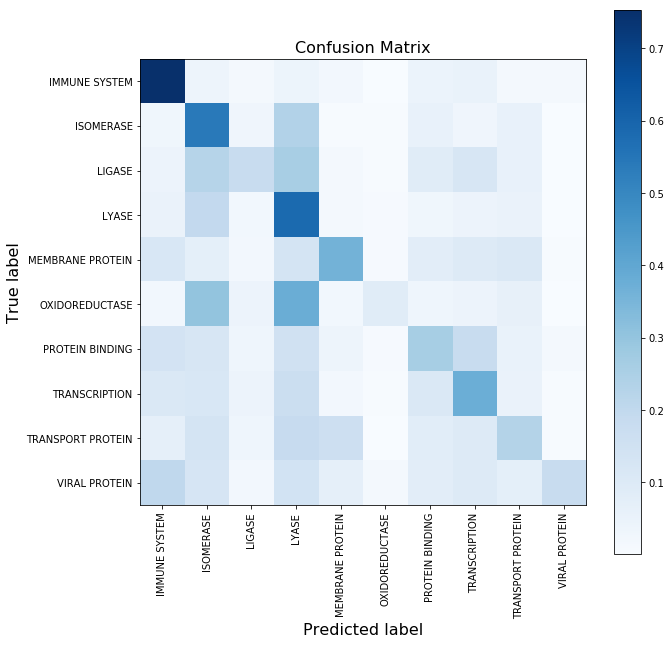

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(cfsn, cmap = plt.cm.Blues)
plt.colorbar()
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes,)
plt.ylabel('True label',fontsize = 16)
plt.xlabel('Predicted label',fontsize = 16)
plt.title('Confusion Matrix', fontsize = 16)